In [27]:
import pandas as pd
import string
import unicodedata
import sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [2]:
data = pd.read_csv('text_emotion.csv')

In [3]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [4]:
smileyfaces = [':-)', ':)', ':D', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)']
sadfaces = ['>:[', ':-(', ':(', ':-c', ':c', ':-<', ':<', ':-[', ':[', ':{', '=(','=[', 'D:']
angryfaces = ['>:(']
cryingfaces = [":’-(", ":’("]
skepticalfaces = ['>:', '>:/', ':-/', '=/',':L', '=L', ':S', '>.<']
noexpressionfaces = [':|', ':-|']
surprisedfaces = ['>:O', ':-O', ':O', ':-o', ':o', '8O', 'O_O', 'o-o', 'O_o', 'o_O', 'o_o', 'O-O']

In [5]:
def cleanText(wordSeries):
    def remove_punctuation(x):
        for char in string.punctuation:
            x = x.replace(char, ' ')
        return x
    for smile in smileyfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(smile, ' smileyface '))
    for sad in sadfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(sad,' sadface '))
    for angry in angryfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(angry, ' angryface '))
    for cry in cryingfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(cry, ' cryingface '))
    for skeptical in skepticalfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(skeptical, ' skepticalface '))
    for noexp in noexpressionfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(noexp, ' noexpressionfaces '))
    for surprised in surprisedfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(surprised, ' surprisedface '))
    wordSeries = wordSeries.apply(lambda x: x.replace('...', ' dotdotdot '))
    wordSeries = wordSeries.apply(lambda x: x.replace('!', ' exclamatory '))
    wordSeries = wordSeries.apply(lambda x: remove_punctuation(x))
    wordSeries = wordSeries.apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
    wordSeries = wordSeries.apply(lambda x: x.lower())
    #wordSeries = wordSeries.apply(lambda x: x.replace('http', ' '))
    wordSeries = wordSeries.apply(lambda x: ' '.join( [w for w in x.split() if len(w)>1] ))
    return wordSeries

In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
def tokenize(documents):
    documents = cleanText(documents)
    docs = [word_tokenize(content) for content in documents]
    stopwords_=set(stopwords.words('english'))
    def filter_tokens(sent):
        return([w for w in sent if not w in stopwords_])
    docs=list(map(filter_tokens,docs))
    lemmatizer = WordNetLemmatizer()
    docs_lemma = [[lemmatizer.lemmatize(word) for word in words] for words in docs]
    return docs_lemma

In [7]:
def labelmood(mood):
    if mood in ['empty', 'sadness', 'worry', 'hate', 'boredom', 'anger']:
        return -1
    elif mood == 'neutral':
        return 0
    else:
        return 1

In [8]:
data['Tokens'] = tokenize(data['content'])
data['positive/negative'] = data['sentiment'].apply(lambda x: labelmood(x))

In [9]:
positive = data[data['positive/negative'] == 1]
negative = data[data['positive/negative'] == -1]
neutral = data[data['positive/negative'] == 0]

In [10]:
import operator
def createDict(token):
    words = {}
    for row in token:
        for word in row:
            if word in words:
                words[word] += 1
            else:
                words[word] = 1
    sorted_d = dict( sorted(words.items(), key=operator.itemgetter(1),reverse=True))
    return sorted_d

In [11]:
positivewords = createDict(positive['Tokens'])
negativewords = createDict(negative['Tokens'])
neutralwords = createDict(neutral['Tokens'])
words = createDict(data['Tokens'])

In [12]:
keys = [k for k in words]
vals = [v for v in words.values()]
keys_p = [k for k in positivewords]
vals_p = [v for v in positivewords.values()]
keys_n = [k for k in negativewords]
vals_n = [v for v in negativewords.values()]
keys_neutral = [k for k in neutralwords]
vals_neutral = [v for v in neutralwords.values()]

In [13]:
import matplotlib.pyplot as plt

plt.barh(keys[:10], vals[:10], align='center')
plt.title("10 most common words")
plt.show()

<Figure size 640x480 with 1 Axes>

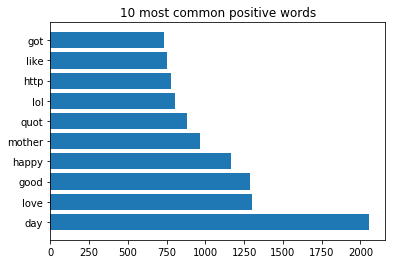

In [23]:
plt.barh(keys_p[2:12], vals_p[2:12], align='center')
plt.title("10 most common positive words")
plt.show()

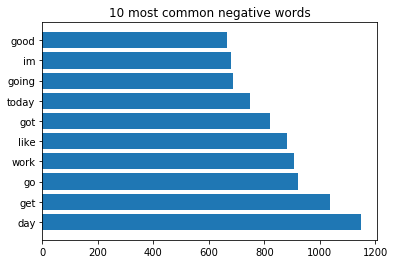

In [24]:
plt.barh(keys_n[2:12], vals_n[2:12], align='center')
plt.title("10 most common negative words")
plt.show()

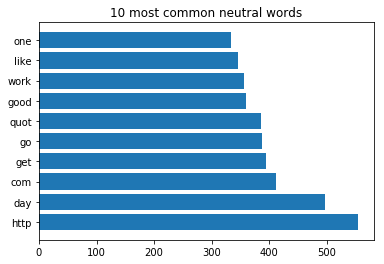

In [25]:
plt.barh(keys_neutral[2:12], vals_neutral[2:12], align='center')
plt.title("10 most common neutral words")
plt.show()

In [17]:
data['tokenJ'] = data['Tokens'].apply(lambda x: ' '.join(x))
corpus = [row for row in data['tokenJ']]

In [18]:
tf = CountVectorizer()

document_tf_matrix = tf.fit_transform(corpus).todense()

tfidf = TfidfVectorizer()
document_tfidf_matrix = tfidf.fit_transform(corpus)

In [19]:
X = document_tfidf_matrix
y = data['sentiment']

In [20]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.25)

In [21]:
lg = LogisticRegression()
lg.fit(Xtrain,ytrain)

/Users/brooks/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/brooks/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [30]:
pred = lg.predict(Xtest)

In [70]:
def getTopN(n, reg, X, y):
    probs = reg.predict_proba(X)
    topN = []
    for prob in probs:
        best_N = list(reversed(np.argsort(prob)))[:n]
        topN.append(best_N)
    topN = np.array(topN)
    mood = np.array(sorted(y.unique()))
    topNpred = mood[topN]
    return topNpred

In [74]:
def getScore(X, y):
    count = 0
    for idx in range(len(y)):
        if np.array(y)[idx] in X[idx]:
            count+=1
    return count/len(y)

In [51]:
probs = lg.predict_proba(Xtest)
top3 = []
for prob in probs:
    best_three = list(reversed(np.argsort(prob)))[:3]
    top3.append(best_three)
top3 = np.array(top3)
mood = np.array(sorted(data['sentiment'].unique()))
top3pred = mood[top3]

In [66]:
np.array(ytest)

array(['worry', 'happiness', 'worry', ..., 'happiness', 'happiness',
       'neutral'], dtype=object)

In [67]:
count = 0
for idx in range(len(ytest)):
    if np.array(ytest)[idx] in top3pred[idx]:
        count+=1
count/len(ytest)

0.6853

In [68]:
lg.score(Xtest, ytest)

0.3462

In [80]:
pred = lg.predict(Xtest)

In [81]:
getScore(pred, ytest)

0.3462